<a href="https://colab.research.google.com/github/vanle2000/Titanic/blob/main/Titanic_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import pandas as pd
import seaborn as sns 
%pylab inline 
import re 
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

Populating the interactive namespace from numpy and matplotlib


# 1. Data preprocessing

## 1.1. Importing Data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
titanic_df = pd.concat([train, test], axis=0)

## 1.2. Handing Missing Values:

In [4]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Descriptive statistic of the training set

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Check the number of null value in training set

In [7]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Dropping the `Cabin` column, since there is 687 missing values and `PassengerId` as we don't need it for training our models.

In [8]:
train.drop('Cabin', axis=1, inplace=True)
train.drop('PassengerId', axis=1, inplace=True)

test.drop('Cabin', axis=1, inplace=True)
test.drop('PassengerId', axis=1, inplace=True)

Next, using `Imputation` technique to treat `Age`, `Embarked` and `Fare` columns with the purpose to fill in missing values with estimated values based on available data. There are mulitple methods for imputing missing data, including:


*   Mean or median imputation: involves filling in missing values with `mean` or `median` value of the variable.
*   Mode imputation: involves filling in missing values with the most common value (`mode`) of the variable.
*   Regression imputation: involves predicting the missing values using `regression` based on the other variables of the dataset. 
*   K-nearest neighbor imputation: involves finding the `k-nearest neighbors` to the observation with missing values and filling in the missing values with the average of those neighbors.
*   Multiple imputation: involves generating multiple imputed datasets by creating pausible values for the missing values based on `statistical models`, and using these datasets to estimate parameters and make predictions. 


Imputing the `Age` column with the `median` value

In [9]:
train['Age'].fillna(titanic_df['Age'].median(), inplace=True)
test['Age'].fillna(titanic_df['Age'].median(), inplace=True)

Imputing the `Embrarked` and `Fare` column with the mode value

In [10]:
train['Embarked'].fillna(titanic_df['Embarked'].mode()[0], inplace=True)
test['Embarked'].fillna(titanic_df['Embarked'].mode()[0], inplace=True)

In [11]:
train['Fare'].fillna(titanic_df['Fare'].mode()[0], inplace=True)
test['Fare'].fillna(titanic_df['Fare'].mode()[0], inplace=True)

Checking for missing values to confirm all missing values in training set have been handled.

In [12]:
print("Train set: ", train.isnull().sum())
print("Test set: ", test.isnull().sum())

Train set:  Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64
Test set:  Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64


Now, define some patterns in our data with visualization

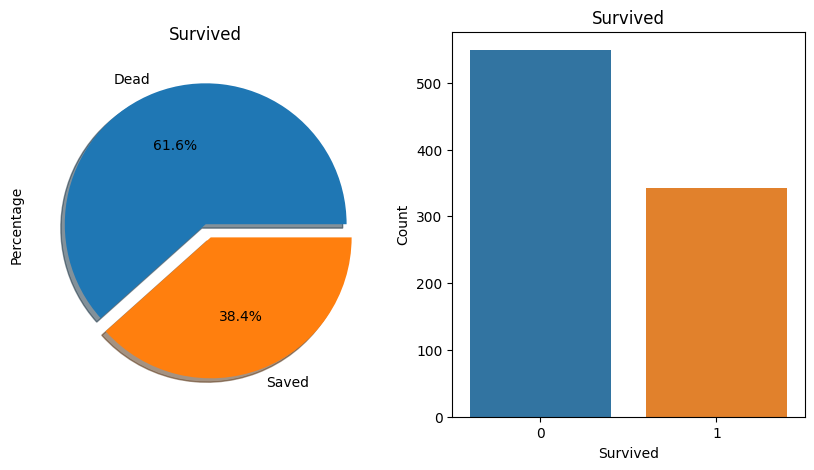

In [13]:
fig, ax = subplots(1, 2, figsize=(10, 5))

# Plot a pie chart showing the survival rate
train['Survived'].value_counts().plot.pie(labels=['Dead', 'Saved'],
                                          explode=[0, 0.1],
                                          autopct='%1.1f%%',
                                          ax=ax[0],
                                          shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('Percentage')

# Plot a bar chart showing the count of survivors
sns.countplot(data=train, x='Survived', ax=ax[1])
ax[1].set_title('Survived')
ax[1].set_ylabel('Count')

show()

Out of the 891 passengers in training dataset, only 38.4% survived.

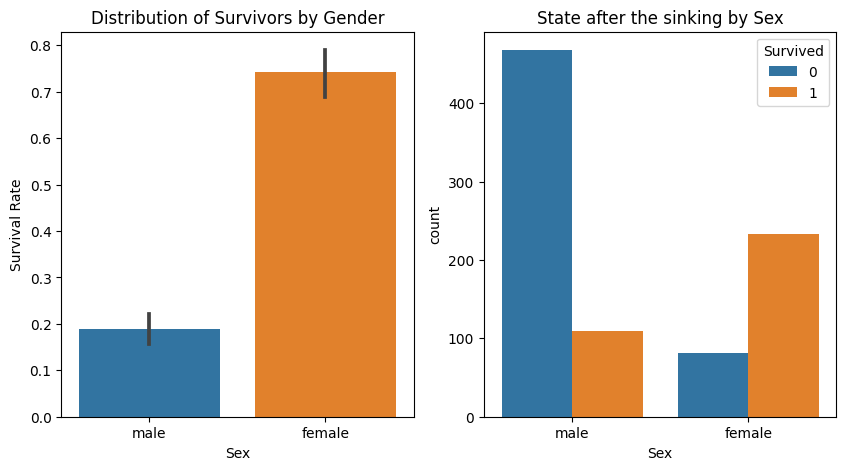

In [14]:
fig, ax = subplots(1, 2, figsize=(10, 5))

# Create a bar plot to show the distribution of survivors between men and women
sns.barplot(x='Sex', y='Survived', data=train, ax=ax[0])
ax[0].set_title('Distribution of Survivors by Gender')
ax[0].set_ylabel('Survival Rate')


# Create a bar plot tp show the survival rate between men and women
sns.countplot(data=train, x='Sex', hue='Survived', ax=ax[1])
ax[1].set_title('State after the sinking by Sex')
show()

The majority of men are on boats, however, female has higher survival rate. 

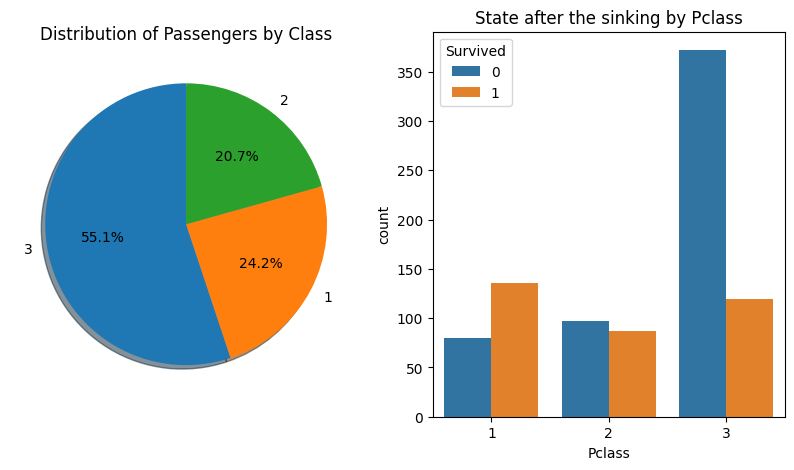

In [15]:
fig, ax = subplots(1, 2, figsize=(10, 5))

# Create a bar plot to show the distribution of Pcalss 
train['Pclass'].value_counts().plot.pie(autopct='%1.1f%%',
                                        ax=ax[0],
                                        shadow=True,
                                        startangle=90)
ax[0].set_title('Distribution of Passengers by Class')
ax[0].set_ylabel('')

# Create a bar plot tp show the survival rate between men and women
sns.countplot(data=train, x='Pclass', hue='Survived', ax=ax[1])
ax[1].set_title('State after the sinking by Pclass')
show()

How the survival rate look like in gender for each class? 

Let's generate a cross-tabulation table showing the number of passengers by gender and survival status in each passenger class. 




In [16]:
pd.crosstab([train['Sex'], train['Survived']], train['Pclass'], margins=True).style.background_gradient(cmap='rocket_r')

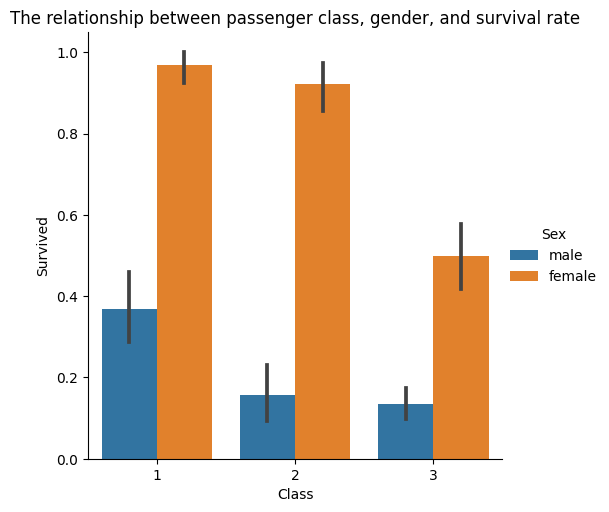

In [17]:
sns.catplot(data=train, x='Pclass', y='Survived', hue='Sex', kind="bar")
gca().set_title('The relationship between passenger class, gender, and survival rate')
gca().set_xlabel('Class')
show()

Female in the first class has the likelihood of more than 95% survival rate.

Let's see how `Age` and `Pclass` determine the survival rate?

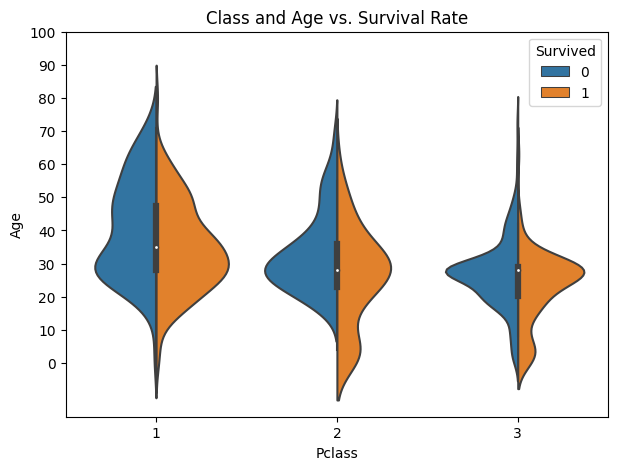

In [18]:
fig, ax = subplots(figsize=(7,5))

sns.violinplot(data=train, x='Pclass', y='Age', hue='Survived', split=True)
ax.set_title('Class and Age vs. Survival Rate')
ax.set_yticks(range(0,110,10))
show()

It looks like the children and mid-age (30s-40s) have the highest survival rate.

## 1.3. Encoding Categorical Variables
There are various method to encode the categorical variables, in this Titanic dataset, we will work with `one-hot encoding`.


In [19]:
cat_vars = ['Sex', 'Embarked']

# Perform one-hot encoding
encoder = ce.OneHotEncoder(cols=cat_vars,
                           handle_unknown='return_nan',
                           return_df=True,
                           use_cat_names=True)

train = encoder.fit_transform(train)
test = encoder.fit_transform(test)

Create `Age Group` and assign its values into 4 bins 

In [20]:
# Define age categories
age_bins = [0, 18, 30, 50, 100]
age_labels = ['1', '2', '3', '4']

# Create new column with the age categories 
train['Age Group'] = pd.cut(train['Age'], bins=age_bins, labels=age_labels)
train.drop('Age', axis=1, inplace=True)
train.head()

 
test['Age Group'] = pd.cut(test['Age'], bins=age_bins, labels=age_labels)
test.drop('Age', axis=1, inplace=True)


In [21]:
test['Age Group'].value_counts().to_frame()

,Age Group
2,232
3,101
1,54
4,31


## 1.4. Feature Engineering

### Title Extraction:

In [22]:
def extract_title(Name):
  try:
    title_pattern = r", \s*([^\.]*)\."
    return re.search(title_pattern, str(Name)).group(1)
  except:
    return "Unknown"

titanic_df['Title'] = titanic_df['Name'].apply(extract_title)


def title_group(df):
    df['Title'] = df['Title'].replace(['Jonkheer', 'Don', 'Sir', 'Capt', 'Col', 'Major', 'Rev', 'Dr'], 'Mr')
    df['Title'] = df['Title'].replace(['Mme', 'the Countess'], 'Mrs')
    df['Title'] = df['Title'].replace(['Lady', 'Ms', 'Mlle'], 'Miss')
    df['Title'] = df['Title'].apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs'] else 'Other')
    
    return df

titanic_df = title_group(titanic_df)

In [23]:
# Group by title and get the count
titanic_df['Title'].value_counts()

Mr       783
Miss     265
Mrs      199
Other     62
Name: Title, dtype: int64

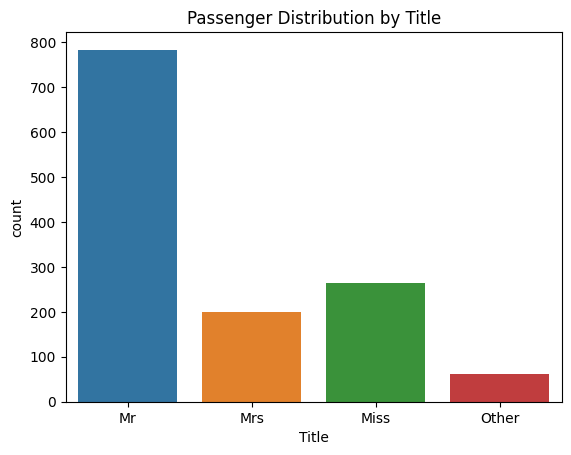

In [24]:
# Bar plot to visualize the distribution of passengers by title
sns.countplot(x='Title', data=titanic_df)
plt.title('Passenger Distribution by Title')
plt.show()

### Family Survival Status:

In [25]:
# Define a function to extract last name from passenger name
def extract_lastname(name):
    return name.split(',')[0]

# Add a column for family size
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

# Add a column for last name
train['LastName'] = train['Name'].apply(extract_lastname)

# Group passengers by last name and family size, and mark each family as either having survived or not
train['FamilySurvival'] = 0.5  # Initialize with 0.5 for families without information
for _, group in train.groupby(['LastName', 'FamilySize']):
    if len(group) > 1:
        # Family with more than one member: check if anyone survived
        family_survival = group['Survived'].max()
        train.loc[group.index, 'FamilySurvival'] = family_survival
    else:
        # Family with one member: use information from the individual
        train.loc[group.index, 'FamilySurvival'] = group['Survived']

print("Number of passengers with family survival information:", train.loc[train['FamilySurvival'] != 0.5].shape[0])

Number of passengers with family survival information: 891


In [27]:
train.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'LastName'], inplace=True)
train.head()

,Survived,Pclass,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Age Group,FamilySize,FamilySurvival
0,0,3,1.0,0.0,1.0,0.0,0.0,2,2,0.0
1,1,1,0.0,1.0,0.0,1.0,0.0,3,2,1.0
2,1,3,0.0,1.0,1.0,0.0,0.0,2,1,1.0
3,1,1,0.0,1.0,1.0,0.0,0.0,3,2,1.0
4,0,3,1.0,0.0,1.0,0.0,0.0,3,1,1.0


# 2. Training Predictive Models
I will train our dataset on 6 models including:


1. Support Vector Classifier (SVC)
2. Random Forest Classifier
3. Decision Tree Classifier 
4. K-Nearest Neighbors Classifier 
5. Logistic Regression
6. Naive Bayes  



Splitting `train` set into `training set` and `validating set` to avoid overfitting.

In [28]:
train, validate = train_test_split(train, test_size=0.3, random_state=0, stratify=train['Survived'])
train_X = train[train.columns[1:]]
train_Y = train[train.columns[:1]]
test_X = validate[validate.columns[1:]]
test_Y = validate[validate.columns[:1]]
X = train[train.columns[1:]]
Y = train['Survived']

### 2.1. Support Vector Classifier

In [ ]:
model = SVC(kernel='rbf', gamma=0,1, random_state=1)
model.fit(train_X, train_Y.values.ravel())
prediction = model.predict(test_X)
print('The accuracy of the Support Vector Classifier is: ', metrics.accuracy_score(prediction, test_Y))

### 2.2. Random Forest Classifier


In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=1)
model.fit(train_X, train_Y.value.ravel())
prediction = model.predict(test_X)
print('The accuracy of the Random Forest Classifier is: ', metrics.accuracy_score(prediction, test_Y))

### 2.3. Decision Tree Classifier

In [ ]:
model = DecisionTreeClassifier(random_state=1)
model.fit(train_X, train_Y)
prediction = model.predict(test_X)
print('The accuracy of the Decision Tree Classifier is: ', metrics.accuracy_score(prediction, test_Y))

### 2.5. Logistic Regression

In [ ]:
model = LogisticRegression(random_state=1)
model.fit(train_X, train_Y.values.ravel())
prediction = model.predict(test_X)
print('The accuracy of the Logistic Regression is: ', metrics.accuracy_score(prediction, test_Y))

### 2.6. Naive Bayes

In [ ]:
model = MultinomialNB()
model.fit(train_X, train_Y.values.ravel())
prediction = model.predict(test_X)
print('The accuracy of the Naive Bayes is: ', metrics.accuracy_score(prediction, test_Y))